In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 600.30 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os

In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [4]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [5]:
tokenizer.get_vocab_size()


544998

In [6]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [7]:
import csv

defense_ips = []
directory = "/home/toibazd/Defense_InterPros/"
file_list = os.listdir(directory)

for file in file_list:
    print(file)
    file_path = os.path.join(directory, file)
    with open(file_path, 'r', newline='') as infile:
        reader = csv.reader(infile, delimiter = "\t")
        next(reader)
        for row in reader:
            ip = row[0]
            defense_ips.append(ip)

LIT_IP.tsv
Toxin-antitoxin.tsv
CRISPR_IP.tsv
BREX_IP.tsv
DISARM_IP.tsv
Druantia.tsv
Abortive_infection.tsv
Kiwa_IP.tsv


In [8]:
print("Defense IPs number: ", len(defense_ips))

Defense IPs number:  183


In [9]:
from collections import defaultdict
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in defense_ips:
                data_dict[key].append(ip)


0it [00:00, ?it/s]

In [10]:
unique_defense = set()

# Iterate through each value list in the dictionary and add its elements to the set
for value_list in data_dict.values():
    unique_defense.update(value_list)

# Convert the set to a list if needed
unique_defense = list(unique_defense)

In [11]:
len(unique_defense)

141

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

2231


In [13]:
one_hot_encoded.shape

(2231, 141)

In [15]:
import os
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

directory = '/ibex/user/toibazd/InterPro_annotated_genomes_training/'
one_hot_encoded_sentences = {}

sentence_length = 40
sentences_per_IP = 100

# Set random seed for reproducibility
random.seed(42)

# Randomly choose 1000 files with seed 42
selected_files = os.listdir(directory)


# Define a function to process a file
def process_file(filename, IP):
    sentences = []

    filepath = os.path.join(directory, filename)

    with open(filepath, 'r') as file:
        content = file.read()
        words = content.strip().split()

        # Check if the key is in the file
        for i in range(19, len(words)-20):
            if IP in data_dict[words[i]]:
                if len(words) - i >= 21:
                    sentence = " ".join(words[i - 19:i + sentence_length - 19])
                    sentences.append(sentence)
    return sentences


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences[IP] = []
    sentences_count = 0

    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
        for future in futures:
            sentences = future.result()
            one_hot_encoded_sentences[IP].extend(sentences)
            sentences_count += len(sentences)
            if sentences_count >= sentences_per_IP:
                break

    # Break if the required number of sentences per key is reached


100%|██████████| 141/141 [1:45:36<00:00, 44.94s/it]


In [16]:
for key, values in one_hot_encoded_sentences.items():
    print(len(values))

106
101
63
100
100
100
100
59
57
16
100
100
100
100
14
100
20
100
100
100
102
69
100
56
100
100
100
100
100
73
100
100
100
100
28
71
18
100
100
100
100
100
100
100
65
100
100
100
101
106
100
23
100
100
100
102
100
51
100
100
101
27
102
100
100
96
100
100
100
100
100
100
100
100
100
101
100
101
100
19
104
100
81
100
102
48
100
100
100
100
48
26
17
100
100
100
100
100
100
100
100
101
100
100
100
100
57
100
100
100
100
100
42
34
84
25
100
33
34
100
100
35
36
19
100
100
49
19
33
100
100
100
100
100
100
100
102
77
33
100
100


In [17]:
import json

with open('BERT_sanity_check_defense_DNN_senteces.json', 'w') as f:
    json.dump(one_hot_encoded_sentences, f)

In [18]:
import json
with open('BERT_sanity_check_defense_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [19]:
for key, value in one_hot_encoded_sentences.items():
    print(key, end=" ")
    print(len(value))

IPR028629 106
IPR007712 101
IPR030987 63
IPR007337 100
IPR017034 100
IPR022597 100
IPR048242 100
IPR013421 59
IPR019092 57
IPR019117 16
IPR022541 100
IPR021228 100
IPR006482 100
IPR019857 100
IPR010160 14
IPR021127 100
IPR013444 20
IPR018669 100
IPR015090 100
IPR025935 100
IPR025253 102
IPR023843 69
IPR017277 100
IPR017574 56
IPR021124 100
IPR044054 100
IPR047679 100
IPR009320 100
IPR013492 100
IPR013403 73
IPR026262 100
IPR025940 100
IPR005510 100
IPR010156 100
IPR013415 28
IPR048067 71
IPR013487 18
IPR021558 100
IPR019851 100
IPR031856 100
IPR010149 100
IPR010144 100
IPR025211 100
IPR047976 100
IPR013419 65
IPR013397 100
IPR013399 100
IPR013382 100
IPR039060 101
IPR019239 106
IPR010179 100
IPR035424 23
IPR010147 100
IPR014174 100
IPR002850 100
IPR039052 102
IPR019855 100
IPR013410 51
IPR025897 100
IPR019238 100
IPR010148 101
IPR016581 27
IPR013430 102
IPR013343 100
IPR011664 100
IPR031709 96
IPR013395 100
IPR013337 100
IPR019504 100
IPR010146 100
IPR024640 100
IPR019858 100
IPR010155

In [20]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

141

In [21]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

141

In [22]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

11987

In [23]:
count= 0
for string in matching_string:
    words = string.split(" ")
    if not words[19] in data_dict.keys():
        print("False")
    else:
        count+=1
print(count)

11987


In [24]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-18 12:49:21,569] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [25]:
print(one_hot_encoded[1])

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
batch_size = 128 # Define your batch size
embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        labels.append(one_hot_encoded_dict[indicator])


100%|██████████| 94/94 [00:02<00:00, 42.35it/s]


In [27]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
print(class_counts.shape)
pos_weights = calculate_pos_weights(class_counts) 

(141,)


In [28]:
pos_weights = pos_weights / torch.min(pos_weights)

pos_weights

tensor([ 1.0000,  9.8333,  7.7500,  8.7500,  2.1667,  9.7500,  3.6667,  4.8333,
         9.8333,  3.2500,  8.5833,  9.5000,  9.8333,  9.8333,  9.8333,  5.1667,
         6.0833,  9.8333,  9.8333,  4.2500,  8.5833,  9.8333, 71.2500, 18.3333,
         7.5000,  9.8333,  9.8333,  9.8333,  4.8333,  9.8333,  9.6667,  6.5000,
         9.8333,  7.9167,  9.8333,  9.8333,  9.8333,  9.8333,  9.8333, 13.5833,
        29.2500,  9.8333, 18.7500,  6.8333,  8.6667,  4.8333, 35.5833,  6.9167,
        14.7500, 16.8333,  9.6667, 49.8333, 55.3333,  9.8333, 47.4167,  9.8333,
         9.8333,  9.8333,  9.8333, 23.0833,  8.3333,  9.8333, 17.7500, 30.1667,
        52.4167, 30.1667,  9.8333,  9.8333, 12.8333,  8.6667, 62.3333,  4.8333,
         9.8333,  9.3333,  9.8333,  4.5833,  9.2500,  9.5000,  9.3333,  9.4167,
         9.8333,  2.3333,  7.3333,  9.8333,  9.8333,  9.8333,  9.8333,  9.8333,
         5.2500,  9.8333,  9.8333,  6.5833, 14.3333, 19.0833,  9.8333,  9.8333,
         9.8333,  9.6667,  9.8333,  9.83

In [29]:
import random

random.seed(42)
combined = list(zip(embeddings, labels))
random.shuffle(combined)
embeddings, labels = zip(*combined)



In [30]:
model.to("cpu")
torch.cuda.empty_cache()

In [33]:
print(embeddings[0])

tensor([-2.3154e-01, -1.1831e-01,  3.1003e-01,  1.4840e-01,  1.5352e-01,
        -1.8559e-01,  9.2390e-02,  5.9158e-01, -1.8190e-01, -4.4440e-01,
        -3.5491e-01, -2.4470e-01, -5.6740e-01, -3.6771e-01, -1.1164e-01,
        -5.9384e-02, -7.8562e-02, -6.6655e-01,  8.4920e-02, -4.6805e-02,
         1.0548e-01, -2.0913e-01,  1.4788e-01, -1.5230e-01,  4.1854e-01,
         8.1110e-02, -3.1939e-01, -5.2419e-01,  7.3082e-03, -3.1820e-01,
         3.5603e-01,  3.8874e-01,  2.0314e-01,  3.7499e-02,  4.5497e-01,
         2.4618e-01,  2.2727e-01,  7.5715e-03,  4.6537e-01,  3.5618e-01,
        -2.9595e-01,  1.6649e-01, -1.2247e-01,  1.8809e-01, -2.1789e-01,
         3.4202e-01,  7.5534e-02, -2.6116e-01, -9.1179e-02, -4.4397e-01,
        -2.2757e-01, -3.8417e-02,  5.5517e-02,  4.9596e-02, -2.0082e-01,
         1.0503e-01, -2.0418e-02, -8.9088e-02, -1.3379e-02, -3.5107e-01,
        -4.3659e-03, -4.4773e-01,  2.2599e-01, -2.2115e-01,  7.9751e-02,
        -2.0281e-01, -6.8589e-01,  1.3862e-01,  2.5

In [31]:
import torch

random_embeddings = []
for embedding in tqdm(embeddings):
    random_embedding = torch.randn_like(embedding)  # Generate random tensor with same shape as 'embedding'
    random_embeddings.append(random_embedding)



100%|██████████| 11987/11987 [00:00<00:00, 153538.56it/s]


In [32]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 256
second_hidden = 128
last_hidden = 64
output_dim = 141
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [34]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels


optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [35]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(random_embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        outputs = clf_model(batch_embeddings_tensor)
        loss = criterion(outputs, batch_labels_tensor)
        train_loss+=loss.item()

        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")

Epoch 1/20:


0.3823930179146916
Epoch 2/20:


0.30351527124864597
Epoch 3/20:


0.2982593150356449
Epoch 4/20:


0.29540641602000395
Epoch 5/20:


0.29235055900708024
Epoch 6/20:


0.2885337435613435
Epoch 7/20:


0.28429692985119054
Epoch 8/20:


0.28096855541002347
Epoch 9/20:


0.2758953211911578
Epoch 10/20:


0.27122503557346017
Epoch 11/20:


0.2630232956328503
Epoch 12/20:


0.2619311755240744
Epoch 13/20:


0.26047538018379773
Epoch 14/20:


0.2595711115592612
Epoch 15/20:


0.25834471725727365
Epoch 16/20:


0.25793687434254947
Epoch 17/20:


0.2569146782042953
Epoch 18/20:


0.25603698643908507
Epoch 19/20:


0.25558421223338834
Epoch 20/20:


0.25456847024339846
Training finished.


In [36]:
directory = '/ibex/user/toibazd/InterPro_annotated_genomes_for_testing/'
one_hot_encoded_sentences_2 = {}

sentence_length = 40
sentence_per_IP = 50
selected_files = os.listdir(directory)

total_sentences = sum(len(sentences) for sentences in one_hot_encoded_sentences.values())

# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences_2[IP] = []
    sentences_count=0
    
    # Iterate over selected files
    for filename in selected_files:
        filepath = os.path.join(directory, filename)

        with open(filepath, 'r') as file:
            content = file.read()
            words = content.strip().split()

            # Check if the key is in the file
            for i in range(19, len(words)-20):
                # Shuffle the indices of the words containing the key
                if IP in data_dict[words[i]]:
                    if len(words) - i >= 21:
                        sentence = " ".join(words[i - 19:i + sentence_length - 19])
                        one_hot_encoded_sentences_2[IP].append(sentence)
                        sentences_count += 1
                        if sentences_count>=sentence_per_IP:
                            break
        if sentences_count>=sentence_per_IP:
            break
    print(sentences_count)
            


  1%|          | 1/141 [00:00<01:55,  1.21it/s]

50
50


  3%|▎         | 4/141 [00:11<06:31,  2.86s/it]

5
50


  4%|▎         | 5/141 [00:14<06:25,  2.84s/it]

50


  4%|▍         | 6/141 [00:15<04:30,  2.01s/it]

50


  5%|▍         | 7/141 [00:17<04:35,  2.06s/it]

50


  6%|▌         | 8/141 [00:26<09:31,  4.30s/it]

23


  6%|▋         | 9/141 [00:35<12:44,  5.79s/it]

8


  7%|▋         | 10/141 [00:44<15:01,  6.88s/it]

3


  8%|▊         | 11/141 [00:45<10:34,  4.88s/it]

50


  9%|▊         | 12/141 [00:47<08:40,  4.03s/it]

50


  9%|▉         | 13/141 [00:48<06:39,  3.12s/it]

50


 10%|▉         | 14/141 [00:50<06:15,  2.96s/it]

50


 11%|█         | 15/141 [01:00<10:20,  4.92s/it]

5


 11%|█▏        | 16/141 [01:00<07:30,  3.61s/it]

50


 12%|█▏        | 17/141 [01:10<10:55,  5.29s/it]

2


 13%|█▎        | 18/141 [01:10<07:49,  3.82s/it]

50


 13%|█▎        | 19/141 [01:13<07:03,  3.47s/it]

50


 14%|█▍        | 20/141 [01:13<05:13,  2.59s/it]

50
50


 16%|█▌        | 22/141 [01:23<07:03,  3.56s/it]

14


 16%|█▋        | 23/141 [01:31<09:31,  4.84s/it]

50


 17%|█▋        | 24/141 [01:41<11:41,  6.00s/it]

10


 18%|█▊        | 25/141 [01:41<08:38,  4.47s/it]

50


 18%|█▊        | 26/141 [01:44<07:57,  4.15s/it]

50


 19%|█▉        | 27/141 [01:47<07:11,  3.78s/it]

50


 20%|█▉        | 28/141 [01:47<05:12,  2.76s/it]

50


 21%|██        | 29/141 [01:50<05:09,  2.76s/it]

50


 21%|██▏       | 30/141 [02:00<08:48,  4.76s/it]

13


 22%|██▏       | 31/141 [02:00<06:26,  3.51s/it]

50


 23%|██▎       | 32/141 [02:03<06:03,  3.34s/it]

50


 23%|██▎       | 33/141 [02:08<06:36,  3.67s/it]

50


 24%|██▍       | 34/141 [02:11<06:13,  3.49s/it]

50


 25%|██▍       | 35/141 [02:20<09:12,  5.21s/it]

4


 26%|██▌       | 36/141 [02:29<11:11,  6.39s/it]

16


 26%|██▌       | 37/141 [02:38<12:32,  7.23s/it]

2


 27%|██▋       | 38/141 [02:42<10:40,  6.22s/it]

50


 28%|██▊       | 39/141 [02:43<07:39,  4.50s/it]

50


 28%|██▊       | 40/141 [02:43<05:27,  3.24s/it]

50


 29%|██▉       | 41/141 [02:49<06:35,  3.95s/it]

50


 30%|██▉       | 42/141 [02:50<05:08,  3.12s/it]

50


 30%|███       | 43/141 [02:50<03:49,  2.34s/it]

50


 31%|███       | 44/141 [02:51<03:01,  1.87s/it]

50


 32%|███▏      | 45/141 [03:00<06:34,  4.10s/it]

5


 33%|███▎      | 46/141 [03:03<05:53,  3.72s/it]

50


 33%|███▎      | 47/141 [03:05<05:03,  3.22s/it]

50


 34%|███▍      | 48/141 [03:06<03:42,  2.39s/it]

50


 35%|███▍      | 49/141 [03:06<02:42,  1.77s/it]

50


 35%|███▌      | 50/141 [03:07<02:15,  1.49s/it]

50


 36%|███▌      | 51/141 [03:08<01:52,  1.25s/it]

50


 37%|███▋      | 52/141 [03:17<05:22,  3.63s/it]

6


 38%|███▊      | 53/141 [03:17<03:55,  2.68s/it]

50


 38%|███▊      | 54/141 [03:26<06:37,  4.57s/it]

31


 39%|███▉      | 55/141 [03:28<05:08,  3.58s/it]

50


 40%|███▉      | 56/141 [03:28<03:44,  2.64s/it]

50


 40%|████      | 57/141 [03:29<02:55,  2.09s/it]

50


 41%|████      | 58/141 [03:38<05:49,  4.21s/it]

12


 42%|████▏     | 59/141 [03:42<05:54,  4.32s/it]

50


 43%|████▎     | 60/141 [03:46<05:21,  3.97s/it]

50


 43%|████▎     | 61/141 [03:46<03:48,  2.86s/it]

50


 44%|████▍     | 62/141 [03:55<06:21,  4.83s/it]

4


 45%|████▍     | 63/141 [03:56<04:30,  3.47s/it]

50


 45%|████▌     | 64/141 [03:57<03:47,  2.96s/it]

50


 46%|████▌     | 65/141 [03:58<02:49,  2.22s/it]

50


 47%|████▋     | 66/141 [04:07<05:24,  4.32s/it]

32


 48%|████▊     | 67/141 [04:10<04:42,  3.82s/it]

50


 48%|████▊     | 68/141 [04:19<06:37,  5.44s/it]

25


 49%|████▉     | 69/141 [04:28<07:50,  6.54s/it]

32


 50%|████▉     | 70/141 [04:32<06:38,  5.61s/it]

50


 50%|█████     | 71/141 [04:41<07:51,  6.74s/it]

38


 51%|█████     | 72/141 [04:42<05:58,  5.19s/it]

50


 52%|█████▏    | 73/141 [04:45<04:59,  4.41s/it]

50


 52%|█████▏    | 74/141 [04:47<04:06,  3.68s/it]

50


 54%|█████▍    | 76/141 [04:47<02:04,  1.91s/it]

50
50


 55%|█████▍    | 77/141 [04:55<03:53,  3.65s/it]

50


 55%|█████▌    | 78/141 [04:57<03:21,  3.20s/it]

50


 56%|█████▌    | 79/141 [04:58<02:28,  2.39s/it]

50


 57%|█████▋    | 80/141 [05:07<04:33,  4.49s/it]

1


 57%|█████▋    | 81/141 [05:08<03:14,  3.23s/it]

50


 58%|█████▊    | 82/141 [05:09<02:34,  2.62s/it]

50


 59%|█████▉    | 83/141 [05:18<04:26,  4.60s/it]

11


 60%|█████▉    | 84/141 [05:27<05:36,  5.91s/it]

39


 60%|██████    | 85/141 [05:36<06:18,  6.76s/it]

50


 61%|██████    | 86/141 [05:45<06:52,  7.50s/it]

8


 62%|██████▏   | 87/141 [05:54<07:08,  7.94s/it]

40


 62%|██████▏   | 88/141 [05:54<04:58,  5.63s/it]

50


 63%|██████▎   | 89/141 [05:57<04:05,  4.72s/it]

50


 64%|██████▍   | 90/141 [05:58<03:11,  3.76s/it]

50


 65%|██████▍   | 91/141 [06:08<04:34,  5.50s/it]

8


 65%|██████▌   | 92/141 [06:17<05:25,  6.64s/it]

1


 66%|██████▌   | 93/141 [06:26<05:55,  7.40s/it]

4


 67%|██████▋   | 94/141 [06:27<04:08,  5.29s/it]

50


 67%|██████▋   | 95/141 [06:36<04:56,  6.45s/it]

21


 68%|██████▊   | 96/141 [06:37<03:33,  4.75s/it]

50


 69%|██████▉   | 97/141 [06:37<02:38,  3.61s/it]

50


 70%|██████▉   | 98/141 [06:38<01:57,  2.74s/it]

50


 70%|███████   | 99/141 [06:47<03:16,  4.69s/it]

45


 71%|███████   | 100/141 [06:57<04:06,  6.02s/it]

43


 72%|███████▏  | 101/141 [06:59<03:17,  4.93s/it]

50
50


 73%|███████▎  | 103/141 [07:03<02:16,  3.59s/it]

50


 74%|███████▍  | 104/141 [07:04<01:49,  2.97s/it]

50


 74%|███████▍  | 105/141 [07:05<01:27,  2.42s/it]

50


 75%|███████▌  | 106/141 [07:07<01:20,  2.31s/it]

50


 76%|███████▌  | 107/141 [07:17<02:27,  4.33s/it]

8


 77%|███████▋  | 108/141 [07:17<01:44,  3.18s/it]

50


 77%|███████▋  | 109/141 [07:20<01:41,  3.18s/it]

50


 78%|███████▊  | 110/141 [07:23<01:34,  3.06s/it]

50


 79%|███████▊  | 111/141 [07:25<01:25,  2.86s/it]

50


 79%|███████▉  | 112/141 [07:30<01:37,  3.38s/it]

50


 80%|████████  | 113/141 [07:39<02:24,  5.14s/it]

7


 81%|████████  | 114/141 [07:48<02:52,  6.39s/it]

10


 82%|████████▏ | 115/141 [07:57<03:07,  7.20s/it]

27


 82%|████████▏ | 116/141 [08:07<03:16,  7.84s/it]

9


 83%|████████▎ | 117/141 [08:17<03:21,  8.39s/it]

27


 84%|████████▎ | 118/141 [08:26<03:19,  8.66s/it]

4


 84%|████████▍ | 119/141 [08:35<03:13,  8.79s/it]

6


 85%|████████▌ | 120/141 [08:36<02:13,  6.34s/it]

50


 86%|████████▌ | 121/141 [08:40<01:53,  5.67s/it]

50


 87%|████████▋ | 122/141 [08:49<02:07,  6.70s/it]

10


 87%|████████▋ | 123/141 [08:58<02:12,  7.35s/it]

1


 88%|████████▊ | 124/141 [09:07<02:14,  7.89s/it]

3


 89%|████████▊ | 125/141 [09:09<01:39,  6.24s/it]

50


 89%|████████▉ | 126/141 [09:10<01:07,  4.53s/it]

50


 90%|█████████ | 127/141 [09:19<01:24,  6.02s/it]

11


 91%|█████████ | 128/141 [09:28<01:30,  7.00s/it]

4


 91%|█████████▏| 129/141 [09:38<01:31,  7.62s/it]

4


 92%|█████████▏| 130/141 [09:38<01:01,  5.62s/it]

50


 93%|█████████▎| 131/141 [09:40<00:43,  4.30s/it]

50


 94%|█████████▎| 132/141 [09:45<00:40,  4.46s/it]

50


 94%|█████████▍| 133/141 [09:47<00:29,  3.73s/it]

50


 95%|█████████▌| 134/141 [09:50<00:24,  3.55s/it]

50


 96%|█████████▌| 135/141 [09:50<00:16,  2.72s/it]

50


 96%|█████████▋| 136/141 [09:58<00:20,  4.05s/it]

50
50


 98%|█████████▊| 138/141 [10:07<00:12,  4.29s/it]

12


 99%|█████████▊| 139/141 [10:16<00:11,  5.52s/it]

9


 99%|█████████▉| 140/141 [10:18<00:04,  4.57s/it]

50


100%|██████████| 141/141 [10:19<00:00,  4.40s/it]

50


In [37]:
for key, value in one_hot_encoded_sentences_2.items():
    print(len(value))

50
50
5
50
50
50
50
23
8
3
50
50
50
50
5
50
2
50
50
50
50
14
50
10
50
50
50
50
50
13
50
50
50
50
4
16
2
50
50
50
50
50
50
50
5
50
50
50
50
50
50
6
50
31
50
50
50
12
50
50
50
4
50
50
50
32
50
25
32
50
38
50
50
50
50
50
50
50
50
1
50
50
11
39
50
8
40
50
50
50
8
1
4
50
21
50
50
50
45
43
50
50
50
50
50
50
8
50
50
50
50
50
7
10
27
9
27
4
6
50
50
10
1
3
50
50
11
4
4
50
50
50
50
50
50
50
50
12
9
50
50


In [38]:
import json

with open('BERT_sanity_check_defense_DNN_senteces_testing.json', 'w') as f:
    json.dump(one_hot_encoded_sentences_2, f)

In [39]:
with open('BERT_sanity_check_defense_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)

In [40]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

141

In [41]:
matching_string = test_sentences.values()
len(matching_string)

141

In [42]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

5313

In [43]:
from bertviz import model_view

batch_size = 128
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]
    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions = True)
    hidden_states = outputs.last_hidden_state
    attentions = outputs.attentions[-1]
    relevant_hidden_states = hidden_states[:, 20, :]  # Extract the 20th token's hidden state
#     for i in range(len(batch_sentences)):
#         if i < 20:
#             att = []
#             extracted_tensor = attentions[i, :, :, :]
#             extracted_tensor = extracted_tensor.unsqueeze(0)
#             print(extracted_tensor.shape)
#             att.append(extracted_tensor)

#             tokens = "[CLS] "+tokenizer.decode(input_ids_list[i])+" [SEP]"
#             tokens = tokens.split(" ")
#             model_view(att, tokens)
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        test_labels.append(one_hot_encoded_dict[indicator])


100%|██████████| 42/42 [00:10<00:00,  3.83it/s]


In [44]:
tokenizer.decode([0,12,12,12,12,
                 ])

'WP_072018053 WP_072018053 WP_072018053 WP_072018053'

In [45]:
model.to("cpu")
torch.cuda.empty_cache()

In [46]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=141, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [47]:
import torch


test_random_embeddings = []
for embedding in test_embeddings:
    random_embedding = torch.randn_like(embedding)  # Generate random tensor with same shape as 'embedding'
    test_random_embeddings.append(random_embedding)

In [48]:
generator = data_generator(test_random_embeddings, test_labels, batch_size)

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []

for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.15).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


In [49]:
len(all_predictions)

42

In [50]:
len(all_labels)
    

42

In [51]:
print(all_predictions[0].shape)

(128, 141)


In [52]:
print(all_labels[0].shape)

(128, 141)


In [53]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [54]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.5609166568495858


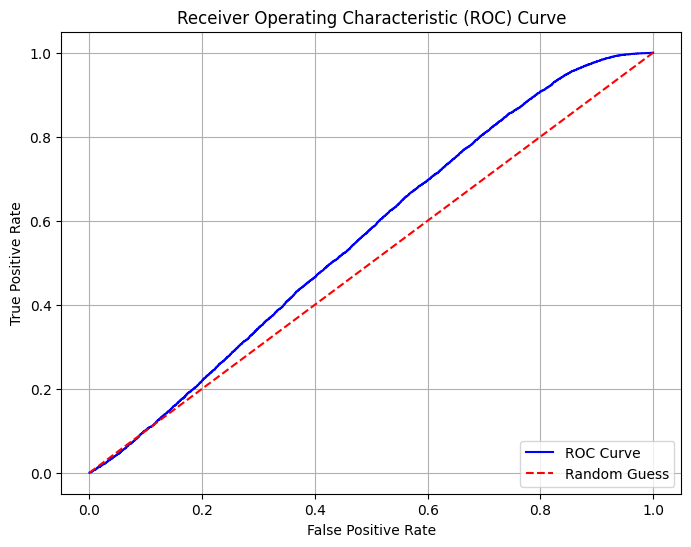

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [56]:
all_labels.shape

(5313, 141)

In [57]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
141


In [58]:
all_predictions[2234]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [59]:
print(cl_report[12])

[[5093  170]
 [  48    2]]


In [60]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions,  zero_division=np.nan)

In [61]:
all_predictions.sum(axis=0)

array([  1., 241., 137., 399.,  29., 159.,  60.,  48.,  40.,  12., 100.,
       235., 172.,  54., 305., 102., 125., 107.,  79.,  29.,  38.,  76.,
       125., 335., 104., 313.,  82., 284.,  84., 141., 125.,  69., 111.,
        82., 245., 147., 111., 180., 224., 158., 168., 267., 105., 208.,
       193., 114., 189., 194., 122., 277., 258.,  89., 116., 107., 137.,
       195., 179., 244., 200., 147., 114., 161., 180., 154., 113., 342.,
        93.,  19., 143., 285., 132., 139., 296., 257., 151.,  14., 100.,
        69., 429.,  87., 125.,   3., 209.,  46.,  72.,  73., 106., 114.,
       157., 252., 150., 183., 245., 191., 481., 121., 140., 166., 204.,
       240.,  54.,  53.,  25., 182.,  56., 299., 182., 152.,  85.,  87.,
        90., 118., 123.,  71., 271., 230., 183., 263., 291., 174., 198.,
       175.,  42., 111., 201.,  94.,  79., 118., 215., 351., 133., 166.,
       288., 145., 141., 411., 248.,  90., 301., 246., 109.],
      dtype=float32)

In [62]:
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       390
           1       0.02      0.08      0.03        50
           2       0.02      0.05      0.03        61
           3       0.02      0.12      0.03        58
           4       0.03      0.01      0.01       190
           5       0.01      0.04      0.02        50
           6       0.00      0.00      0.00       105
           7       0.00      0.00      0.00       100
           8       0.03      0.02      0.02        50
           9       0.00      0.00      0.00       150
          10       0.01      0.02      0.01        64
          11       0.01      0.06      0.02        50
          12       0.01      0.04      0.02        50
          13       0.00      0.00      0.00        50
          14       0.01      0.04      0.01        50
          15       0.00      0.00      0.00        88
          16       0.00      0.00      0.00        75
          17       0.03    

In [63]:
list(enc.classes_)[36]

'IPR013397'

In [59]:
# from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
# import matplotlib.pyplot as plt
# num_classes = 83
# # Compute precision, recall, and thresholds for each class
# precision = dict()
# recall = dict()
# thresholds = dict()
# average_precision = dict()

# for i in range(num_classes):  # num_classes is the number of classes
#     precision[i], recall[i], thresholds[i] = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
#     average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

# # Compute micro-average precision-recall curve and AUC
# precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
# average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# # Compute ROC curve and AUC
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
#     roc_auc[i] = roc_auc_score(all_labels[:, i], all_predictions[:, i])

# # Compute micro-average ROC curve and AUC
# fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
# roc_auc["micro"] = roc_auc_score(all_labels, all_predictions, average="micro")

# # Split classes into groups of 10
# class_groups = [list(range(i, min(i + 10, num_classes))) for i in range(0, num_classes, 10)]

# # Plot Precision-Recall and ROC curves for each group
# for group in class_groups:
#     plt.figure(figsize=(12, 6))

#     # Plot Precision-Recall curve
#     plt.subplot(1, 2, 1)
#     plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (AUPR = {0:0.2f})'
#                  ''.format(average_precision["micro"]))
#     for i in group:
#         plt.step(recall[i], precision[i], where='post', label='Precision-recall curve of class {0} (AUPR = {1:0.2f})'
#                  ''.format(i, average_precision[i]))

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('Precision-Recall curve (Classes {})'.format(group))
#     plt.legend(loc="best")

#     # Plot ROC curve
#     plt.subplot(1, 2, 2)
#     plt.plot(fpr['micro'], tpr['micro'], label='Micro-average ROC curve (AUC = {0:0.2f})'
#                  ''.format(roc_auc["micro"]))
#     for i in group:
#         plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
#                  ''.format(i, roc_auc[i]))

#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC curve (Classes {})'.format(group))
#     plt.legend(loc="best")

#     plt.tight_layout()
#     plt.show()


In [60]:
# import nltk
# import sklearn

# print('The nltk version is {}.'.format(nltk.__version__))
# print('The scikit-learn version is {}.'.format(sklearn.__version__))